# Part 5: Fan base prediction

I will train a binary classifier to predict the location of the author of a tweet (Washington
or Massachusetts), given only the textual content of the tweet. I will try different classification algorithms (at least 3). For each, I will plot ROC curve, report confusion matrix, and calculate accuracy, recall and
precision.

## Importing libraries

In [56]:
import re
import csv
import json #for loading data
import random
import numpy as np
from sklearn import svm 
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Dictionaries with city names in WA and MA

The tweets will have the city names.

In [57]:
WA = ["Washington", "WASHINGTON", "WA", "Aberdeen", "ABERDEEN", "Anacortes", "ANACORTES", 
      "Auburn", "AUBURN", "Bellevue", "BELLEVUE", "Bellingham", "BELLINGHAM", "Bremerton", "BREMERTON", 
      "Centralia", "CENTRALIA", "Coulee Dam", "COULEE DAM", "Coupeville", "COUPEVILLE", "Ellensburg", 
      "ELLENSBURG", "Ephrata", "EPHRATA", "Everett", "EVERETT", "Hoquiam", "HOQUIAM", "Kelso", "KELSO", 
      "Kennewick", "KENNEWICK", "Longview", "LONGVIEW", "Moses Lake", "MOSES LAKE", "Oak Harbor", 
      "OAK HARBOR", "Olympia", "OLYMPIA", "Pasco", "PASCO", "Point Roberts", "POINT ROBERTS", 
      "Port Angeles", "PORT ANGELES", "Pullman", "PULLMAN", "Puyallup", "PUYALLUP", "Redmond", "REDMOND", 
      "Renton", "RENTON", "Richland", "RICHLAND", "Seattle", "SEATTLE", "Spokane", "SPOKANE", "Tacoma",
      "TACOMA", "Walla Walla", "WALLA WALLA", "Wenatchee", "WENATCHEE", "Yakima", "YAKIMA"]

MA = ["Massachusetts", "MASSACHUSETTS", "MA", "Abington", "ABINGTON", "Adams", "ADAMS", "Amesbury", 
      "AMESBURY", "Amherst", "AMHERST", "Andover", "ANDOVER", "Arlington", "ARLINGTON", "Athol", "ATHOL", 
      "Attleboro", "ATTLEBORO", "Barnstable", "BARNSTABLE", "Bedford", "BEDFORD", "Beverly", "BEVERLY", 
      "Boston", "BOSTON", "Bourne", "BOURNE", "Braintree", "BRAINTREE", "Brockton", "BROCKTON", "Brookline", 
      "BROOKLINE", "Cambridge", "CAMBRIDGE", "Canton", "CANTON", "Charlestown", "CHARLESTOWN", "Chelmsford", 
      "CHELMSFORD", "Chelsea", "CHELSEA", "Chicopee", "CHICOPEE", "Clinton", "CLINTON", "Cohasset", 
      "COHASSET", "Concord", "CONCORD", "Danvers", "DANVERS", "Dartmouth", "DARTMOUTH", "Dedham", "DEDHAM", 
      "Dennis", "DENNIS", "Duxbury", "DUXBURY", "Eastham", "EASTHAM", "Edgartown", "EDGARTOWN", "Everett", 
      "EVERETT", "Fairhaven", "FAIRHAVEN", "Fall River", "FALL RIVER", "Falmouth", "FALMOUTH", "Fitchburg", 
      "FITCHBURG", "Framingham", "FRAMINGHAM", "Gloucester", "GLOUCESTER", "Great Barrington",
      "GREAT BARRINGTON", "Greenfield", "GREENFIELD", "Groton", "GROTON", "Harwich", "HARWICH", "Haverhill",
      "HAVERHILL", "Hingham", "HINGHAM", "Holyoke", "HOLYOKE", "Hyannis", "HYANNIS", "Ipswich", "IPSWICH", 
      "Lawrence", "LAWRENCE", "Lenox", "LENOX", "Leominster", "LEOMINSTER", "Lexington", "LEXINGTON", 
      "Lowell", "LOWELL", "Ludlow", "LUDLOW", "Lynn", "LYNN", "Malden", "MALDEN", "Marblehead", "MARBLEHEAD", 
      "Marlborough", "MARLBOROUGH", "Medford", "MEDFORD", "Milton", "MILTON", "Nahant", "NAHANT", "Natick", 
      "NATICK", "New Bedford", "NEW BEDFORD", "Newburyport", "NEWBURYPORT", "Newton", "NEWTON", "North Adams", 
      "NORTH ADAMS", "Northampton", "NORTHAMPTON", "Norton", "NORTON", "Norwood", "NORWOOD", "Peabody", 
      "PEABODY", "Pittsfield", "PITTSFIELD", "Plymouth", "PLYMOUTH", "Provincetown", "PROVINCETOWN", 
      "Quincy", "QUINCY", "Randolph", "RANDOLPH", "Revere", "REVERE", "Salem", "SALEM", "Sandwich", 
      "SANDWICH", "Saugus", "SAUGUS", "Somerville", "SOMERVILLE", "South Hadley", "SOUTH HADLEY", 
      "Springfield", "SPRINGFIELD", "Stockbridge", "STOCKBRIDGE", "Stoughton", "STOUGHTON", "Sturbridge", 
      "STURBRIDGE", "Sudbury", "SUDBURY", "Taunton", "TAUNTON", "Tewksbury", "TEWKSBURY", "Truro", "TRURO", 
      "Watertown", "WATERTOWN", "Webster", "WEBSTER", "Wellesley", "WELLESLEY", "Wellfleet", "WELLFLEET",
      "West Bridgewater", "WEST BRIDGEWATER", "West Springfield", "WEST SPRINGFIELD", "Westfield", 
      "WESTFIELD", "Weymouth", "WEYMOUTH", "Whitman", "WHITMAN", "Williamstown", "WILLIAMSTOWN", "Woburn", 
      "WOBURN", "Woods Hole", "WOODS HOLE", "Worcester", "WORCESTER"]

## To pre-process the tweets into content list and labels

In [58]:
tweet_highlight = []
location_set = set([]) 
location_list = []
tweet_labels = []

file_in = open('./Training_data/tweets_#superbowl.txt', encoding = "utf8")

for line in file_in:
    tr_data = json.loads(line)
    tweet_highlight.append(tr_data['highlight']) #It contains the highlight of the tweet
    location_set.add(tr_data['tweet']['user']['location']) #Unique set of location for each tweet.
    location_list.append(tr_data['tweet']['user']['location']) 
    
selected_WA = set([])
selected_MA = set([])
WA_set = set(WA)
MA_set = set(MA)

#We will use count_set_WA to create selected_WA set
count_set_WA = 0
count_set_MA = 0
location_to_include = WA + MA

for state in location_to_include:
    for location in location_set:
        if state in location:
            if state in WA_set and 'DC' not in location and 'D.C.' not in location: #Since we will be removing punctuation
                selected_WA.add(location)
                count_set_WA += 1
            elif state in MA_set:
                selected_MA.add(location)
                count_set_MA += 1


In [59]:
location_set

{'',
 '#Earth #MEX #Baja',
 'Carlsbad, SoCal',
 'Comedy & Moderation',
 'Salvador Bahia Brasil.',
 'Brooklyn via Jersey',
 'Uk ',
 'Rio Grande Valley, Texas',
 'Harlingen, Texas',
 'instagram: franchus4t',
 'Hyderabad,India / St Louis,USA',
 'In the pursuit of Love   DF.mx',
 'Valmiera ',
 'sunshine state.',
 'Liberty University ',
 'Boleita, Venezuela',
 'S.Fla.',
 'München / Munich',
 'PO Box 592 Walkersville, MD',
 "C'ville, Virginia",
 'Stratford ON, and the interweb',
 'Napa Valley ☆ California',
 'Strasbourg, France',
 'home sweet home, MI',
 'Pacific Northwestish',
 "6'1 ",
 'A medio camino entre tú y yo',
 'Margate City, NJ',
 'Temuco - Chile',
 'Greater New York Area',
 "41° 48' 42 N / 87° 41' 14 W",
 'Heck',
 'Hamilton County, Indiana',
 'Sawbridgeworth',
 '¤My Grind Never Sleeps¤',
 'Flor de Mayo ',
 'Brooklyn, NYC  ',
 'Jackson, MO, USA',
 'ÜT: 39.019646,-84.50122',
 'where F1 is',
 '64 North Orange Avenue Orlando',
 'RALEIGH 35.8189° N, 78.6447° W',
 'The pine tree state '

In [60]:
location_list

['#Seahawks #Mariners ',
 '',
 'k-town Ak.',
 'Brazil',
 'Iowa',
 'http://ask.fm/lKatzPerryl',
 'Cloud 9',
 'LATINOAMÉRICA',
 'Westcoast right near da beach',
 'Boston, MA',
 'Gran Canaria Madrid Londres LA',
 'Phoenix Valleywide',
 '',
 'Seattle',
 'the USA',
 'Bogota, Colombia',
 'Victor, New York',
 'Tampa Bay, Florida',
 'Memphis, TN',
 'London, UK',
 'Canada',
 'Worldwide',
 'Huntsville, AL',
 '',
 '',
 'So. Cal and Vegas',
 'Phoenix, AZ',
 '',
 '',
 'High Point, NC',
 'High Point, NC',
 '',
 'Washington',
 'Souf London',
 'High Point, NC',
 'West Seattle, Wa',
 'Kuantan,Malaysia',
 'West Seattle, Wa',
 '',
 'Pasadena TX',
 '',
 'Arroyomolinos',
 'London',
 'New York',
 'From Diego to the Bay',
 'From Diego to the Bay',
 'Madrid',
 'Madrid',
 '',
 'London, baby',
 '',
 'Halifax, Nova Scotia',
 '',
 'Atlanta',
 '',
 'Holsworthy, Sydney, Australia',
 '',
 '',
 'Philippines',
 'Niagara Falls,ON',
 'Washington, DC',
 'Indiana, USA',
 'North Yorkshire',
 '',
 '',
 '',
 '',
 'PLYMOUTH',

In [4]:
count_list_WA = 0
count_list_MA = 0

for location in location_list:
    if location in selected_WA:
        count_list_WA += 1
        tweet_labels.append(1)
    elif location in selected_MA:
        count_list_MA += 1
        tweet_labels.append(-1)
    else:
        tweet_labels.append(0)

## To remove the non-related tweets and labels

In [20]:
content_list = []
true_labels = []

for (token, label) in zip(tweet_highlight, tweet_labels):
    if label != 0:
        content_list.append(token)
        true_labels.append(label)

true_labels

[-1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 

In [61]:
content_list

['Our @ButchStearns talked #Patriots w/3X #SuperBowl champ Matt Light Full interview @ 10 http://t.co/6s9XqUUcyj #FOX25 http://t.co/iTAFnwQc2G',
 '#MondayMotivation #GOHAWKS #SEAHAWKS #superbowlbound #bodypaint  Happy Monday! &lt;3 http://t.co/MD0vGhP72K',
 'Interview With the Seattle Seahawks Superbowl Champions http://t.co/4HS6DYeOxV #Gohawks #superbowlxlviii #NFL #ESPN',
 "@DougBaldwinJr just this #mediocre #SuperBowlChampion wide receiver #GoHawks #RePete http://t.co/HUwZhG6JwQ's video http://t.co/wE4PP5YaHd",
 "Just a #SuperBowlChampion  #Pedestrian wide receiver #GoHawks #RePete http://t.co/HUwZhG6JwQ's video http://t.co/XYQxeG6u6k",
 'Catch the greatest show on earth with us!\n#SuperBowlXLIX \nbook your table now!\nhttps://t.co/kFuicYAige',
 '@jc_nogales Sunday February 1st. Se juega en Arizona #SuperBowlXLIX',
 '@Deadspin Is it worse than #NFL with #Patriots losing to the #Giants in the #Superbowl? Twice?',
 'Interview With the Seattle Seahawks Superbowl Champions http://t.co/z

In [62]:
#Creating true_labels.csv for classification purposes:
with open('true_labels.csv', 'w') as f:
    writer = csv.writer(f)
    for val in true_labels:
        writer.writerow([val])

## To remove the punctuations and stems

I will use SnowballStemmer for stemming (sing, sang, sung will be considered as sing).
I will also remove punctuations and that's why we didn't include D.C.

In [63]:
stemmer = SnowballStemmer("english")
punctuations = '[! \" # $ % \& \' \( \) \* + , \- \. \/ : ; < = > ? @ \[ \\ \] ^ _ ` { \| } ~]'

def remove_punctuations_and_stems(data_list):
    for i in range(len(data_list)):
        data_list[i] = re.sub(r"https?:\/\/\S+", '', data_list[i])
        data_list[i] = " ".join([stemmer.stem(data) for data in re.split(punctuations, data_list[i])])
        data_list[i] = data_list[i].replace('\n', '').replace('\t', '').replace('\r', '')

remove_punctuations_and_stems(content_list)

## To convert the content list into TF-IDF and build data frame

In [64]:
#It will first count the words and create a vocabulary of words important in the content_list
count_vector = CountVectorizer(stop_words='english')
X_counts = count_vector.fit_transform(content_list)

#This will create tf-idf matrix
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

## To save the sparse tf-idf matrix to a separate file and read the file next time to fasten the process

In [65]:
def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

## Helper function to print out the classification report

In [66]:
def classification_report(truth, prediction, classifier):
    print('\n              Classification report:')
    print('-------------------------------------------------------')
    print('Classifier: ' + classifier)

    print('-------------------------------------------------------')
    print(metrics.classification_report(truth, prediction, target_names=["Washington", "Massachusetts"]),)
    print('-------------------------------------------------------\n')

    print('Confusion Matrix:')
    print('--------------')
    print(metrics.confusion_matrix(truth, prediction))
    print('--------------\n')

    print('Total accuracy: ')
    print(np.mean(prediction == truth))
    print('\n\n')

    return(np.mean(prediction == truth))

## To print the ROC Curve

In [67]:
def roc(truth, score, model):
    fpr, tpr, threshold = roc_curve(truth, score, pos_label=1)
    line = [0, 1]
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.title('ROC-Curve for '+model, fontsize=16)
    plt.axis([-0.004, 1, 0, 1.006])
    #plt.show()
    plt.savefig(model+".png")
    plt.show()
    plt.close()

## Dimensionality reduction using SVD before classification

In [68]:
save_sparse_csr('x-tfidf', X_tfidf)

In [69]:
X_tfidf = load_sparse_csr('x-tfidf.npz')
csv_in = open('true_labels.csv', 'r')
reader = csv.reader(csv_in, delimiter=',')
#true_labels = list()
#for row in reader:
#    true_labels.append(row[0])
true_labels = list(csv.reader(csv_in, delimiter=',')) #Contains null values too.
true_labels = [x for x in true_labels if x] #removes null values
true_labels = np.array(true_labels) #Creating an array
true_labels = true_labels.T.tolist()[0]
true_labels = list(map(int, true_labels))
print(len(true_labels))

54916


In [70]:
accuracy = []
sample = random.sample(range(0, 54916), 10000)

X_sample = X_tfidf[sample]
label_sample = [true_labels[i] for i in sample]
svd = TruncatedSVD(n_components=3, n_iter=10, random_state=42, algorithm='arpack')
svd.fit(X_tfidf)
LSI = svd.transform(X_tfidf)

test_set = random.sample(range(0, 54916), 3000)
train_set = [i for i in range(0, 54916) if i not in set(test_set)]
LSI_test = LSI[test_set]
true_label_test = [true_labels[i] for i in test_set]

LSI_train = LSI[train_set]
true_label_train = [true_labels[i] for i in train_set]

## Classification with SVM (5-cross-validation)


              Classification report:
-------------------------------------------------------
Classifier: SVM(test set)
-------------------------------------------------------
               precision    recall  f1-score   support

   Washington       0.74      0.95      0.83      1740
Massachusetts       0.89      0.53      0.66      1260

    micro avg       0.78      0.78      0.78      3000
    macro avg       0.81      0.74      0.75      3000
 weighted avg       0.80      0.78      0.76      3000

-------------------------------------------------------

Confusion Matrix:
--------------
[[1660   80]
 [ 593  667]]
--------------

Total accuracy: 
0.7756666666666666





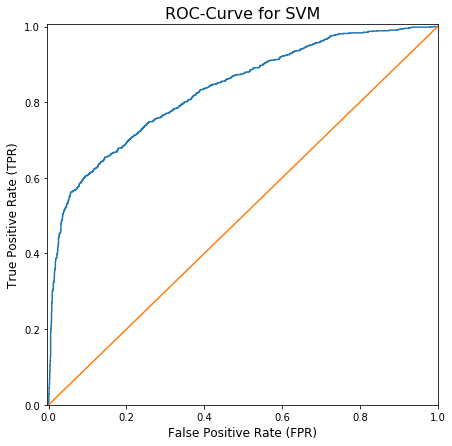

In [71]:
classifier = svm.SVC(gamma=6)

# Try the random-generated test/training set.
classifier.fit(LSI_train, true_label_train)
predicted_labels = classifier.predict(LSI_test)
scores = classifier.decision_function(LSI_test)

classification_report(true_label_test, predicted_labels, 'SVM(test set)')
roc(true_label_test, scores,'SVM')

## Logistic Regression

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



              Classification report:
-------------------------------------------------------
Classifier: Logistic Regression
-------------------------------------------------------
               precision    recall  f1-score   support

   Washington       0.74      0.95      0.83      1740
Massachusetts       0.89      0.54      0.67      1260

    micro avg       0.78      0.78      0.78      3000
    macro avg       0.81      0.74      0.75      3000
 weighted avg       0.80      0.78      0.76      3000

-------------------------------------------------------

Confusion Matrix:
--------------
[[1652   88]
 [ 580  680]]
--------------

Total accuracy: 
0.7773333333333333





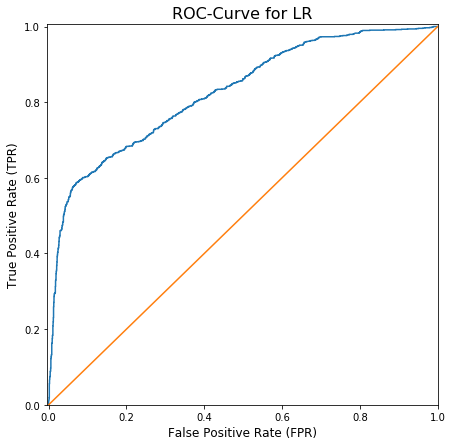

In [72]:
classifier = LogisticRegression()
classifier.fit(LSI_train, true_label_train)
predicted_labels = classifier.predict(LSI_test)
predict_probability = classifier.predict_proba(LSI_test[:])[:, 1]

accuracy.append(classification_report(true_label_test, predicted_labels, 'Logistic Regression'))
roc(true_label_test, predict_probability,'LR')

The dimension reduction does not improve the classification performance as much as we
expected in Logistic Regression. The reason for this could be that the tweet content is quite short
containing much less information. So, the dimension reduction results in causing information or
feature loss in this case. 

Overall, the Logistic Regression classifier has accuracy of 0.777, and the low recall of
classifying tweets from Massachusetts. This can be further improvised and optimized

SVM vs LR:
Similar to the Logistic Regression, the recall for Massachusetts located tweet is very low. We
could see that, the SVM classification has accuracy comparable to Logistic Regression. Also, it
performs very well in classifying tweets posted by users from Washington state.

## Classification with RF (5-cross-validation)

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



              Classification report:
-------------------------------------------------------
Classifier: RF
-------------------------------------------------------
               precision    recall  f1-score   support

   Washington       0.75      0.86      0.81      1740
Massachusetts       0.77      0.61      0.68      1260

    micro avg       0.76      0.76      0.76      3000
    macro avg       0.76      0.74      0.74      3000
 weighted avg       0.76      0.76      0.75      3000

-------------------------------------------------------

Confusion Matrix:
--------------
[[1503  237]
 [ 488  772]]
--------------

Total accuracy: 
0.7583333333333333





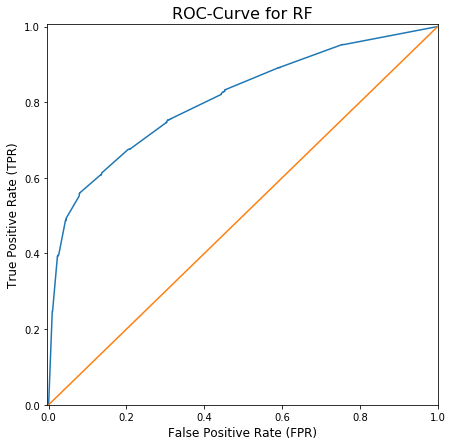

In [73]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

# Try the random-generated test/training set.
classifier.fit(LSI_train, true_label_train)
predicted_labels = classifier.predict(LSI_test)
#scores = classifier.decision_function(LSI_test)
predict_probability = classifier.predict_proba(LSI_test[:])[:, 1]
classification_report(true_label_test, predicted_labels, 'RF')
roc(true_label_test, predict_probability,'RF')

For the third classifier, we use the ensemble method of Random Forests, and observed that it
performs comparable to LR and SVM (although a tad bit better), with a similar precision and
recall for WA and MA; accuracy of WA being higher than MA.